# Multilabel text classification using BERT family

from: 
https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=Lk6Cq9duKBkA

## Setup

In [1]:
import os

# remove any unwanted garbage using the collector
import gc
gc.collect()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchmetrics
import torch
import torch.nn as nn 
import tqdm.notebook as tq
import warnings

from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import BertTokenizerFast as BertTokenizer
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, multilabel_confusion_matrix


2023-07-06 21:09:01.747387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!nvidia-smi

/bin/bash: /home/aurelie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Thu Jul  6 21:09:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  Off |
| 30%   34C    P8    34W / 450W |  11687MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

In [3]:
# Setup torch
torch.set_float32_matmul_precision('high')
torch.manual_seed(42)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
output_path = path + "/outputs"
fig_path = path + "/figs"

In [5]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [6]:
torch.set_float32_matmul_precision('high')
torch.manual_seed(42)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["require_grad"] = "False"

## Load Dataset

In [9]:
## load data (takes around 1min30s)
df_train = pd.read_pickle(os.path.join(data_path, "train_dataset_for_DL.pkl"))
print("Train dataset: ", df_train.shape)
df_test = pd.read_pickle(os.path.join(data_path, "test_dataset_for_DL.pkl"))
print("Test dataset: ", df_test.shape)
df_valid100 = pd.read_pickle(os.path.join(data_path, "valid100_dataset_for_DL.pkl"))
print("Validation dataset: ", df_valid100.shape)

Train dataset:  (125220, 103022)
Test dataset:  (29227, 103022)
Validation dataset:  (100, 103022)


In [10]:
# Check memory space
print("train dataset memory usage: ", df_train.info())
print()
print("ntest dataset memory usage: ", df_test.info())
print()
print("validation dataset memory usage: ", df_valid100.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125220 entries, 0 to 125219
Columns: 103022 entries, !Xóõ (langue) to descr
dtypes: Sparse[int64, 0](103021), object(1)
memory usage: 4.8+ MB
train dataset memory usage:  None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29227 entries, 0 to 29226
Columns: 103022 entries, !Xóõ (langue) to descr
dtypes: Sparse[int64, 0](103021), object(1)
memory usage: 1.1+ MB
ntest dataset memory usage:  None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 103022 entries, !Xóõ (langue) to descr
dtypes: Sparse[int64, 0](103021), object(1)
memory usage: 4.1+ KB
validation dataset memory usage:  None


In [11]:
## Show columns
print("Features: ", df_train.columns)

Features:  Index(['!Xóõ (langue)', '"Sprach- und Sachatlas Italiens und der Südschweiz"',
       '"Taalatlas van Noord- en Zuid-Nederland"', ''?d', ''?ntokyo',
       ''Are'are (peuple des îles Salomon)', ''Au keto',
       ''Au keto, Musique d'', ''Au ni aau', ''Au ni aau, Musique d'',
       ...
       'évangéliaire de split', 'Ālāp', 'Ārbajo, Musique d'',
       'Đinh pơng, Musique de', 'Ō-tsuzumi, Musique d'', 'ʿArūbi', 'Ḥawfi',
       'Ṭhumrī', 'Ṭār (tambour), Musique de', 'descr'],
      dtype='object', length=103022)


In [12]:
# get one row
row_id = 64
label_cols = df_train.columns[:-1]
sample_row = df_train.iloc[row_id]
sample_descr = sample_row.descr
sample_labels = sample_row[label_cols]

print("Description: ", sample_descr)
print("Concepts: ", sample_labels[sample_labels != 0].to_dict())


Description:  La bataille mondiale des matières premières Dans le débat sur un nouvel ordre économique international, les marchés mondiaux des matières premières constituent un enjeu de première importance. Ils conditionnent largement les moyens de financement du développement de pays pauvres et sont un des lieux stratégiques où se joue l'indépendance des pays. L'auteur analyse d'abord les mécanismes et les acteurs des marchés libres, mettant en lumière les limites du jeu libéral de l'offre et de la demande. Son examen des divers systèmes de régulation qui ont été expérimentés l'amènent ensuite à émettre de sérieuses réserves sur l'efficacité des stocks régulateurs. De même, les accords compensatoires (type prêts du FMI) se heurtent-ils à des difficultés théoriques et concrètes de mise en place. La régulation de l'offre n'a véritablement réussi que dans le cas du pétrole. Des solutions plus radicales existent en dehors d'un fonctionnement aménagé du marché : ouverture unilatérale des f

In [13]:
# Sample datasets
df_train = df_train.sample(n=10000, random_state=42)
print("Train dataset: ", df_train.shape)
#df_test = df_test.sample(n=3000, random_state=42)
print("Test dataset: ", df_test.shape)

Train dataset:  (10000, 103022)
Test dataset:  (29227, 103022)


In [14]:
# Remove useless columns (labels not used in train dataset - Takes > 5min)
cols_to_remove = df_train.columns[df_train.sum() == 0]
len(cols_to_remove)

95077

In [15]:
# Remove useless columns
df_train = df_train.drop(columns=cols_to_remove)
print("Train dataset:", df_train.shape)
df_test = df_test.drop(columns=cols_to_remove)
print("Test dataset:", df_test.shape)
df_valid100 = df_valid100.drop(columns=cols_to_remove)
print("Validation dataset:", df_valid100.shape)
label_cols = df_train.columns[:-1]
print("Nombre de labels:", len(label_cols))

Train dataset: (10000, 7945)
Test dataset: (29227, 7945)
Validation dataset: (100, 7945)
Nombre de labels: 7944


In [16]:
# Separate train dataset into train and validation sets for model 
from sklearn.model_selection import train_test_split
data_train, data_val = train_test_split(df_train, test_size = 0.25)
print(data_train.shape, data_val.shape)

(7500, 7945) (2500, 7945)


In [17]:
labels = data_train.columns[:-1]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
print(len(labels))

7944


## Build the model

In [18]:
# Build Deep Learning Model with BERT/PyTorch
from transformers import AutoTokenizer
BERT_MODEL_NAME = 'bert-base-multilingual-cased'
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [19]:
# Select one example
id = 56
example = data_train.iloc[id]
text = example.descr
text

'Cap 2030 : une décennie pour changer le monde Et si on vous offrait la possibilité de changer le monde ? C’est ce qui est arrivé en 2020 à 150 Français tirés au sort pour participer à la Convention citoyenne pour le climat. Tous ont reçu un électrochoc en réalisant l’urgence écologique. À la fois expérience inédite de démocratie participative et feuille de route pour réduire les émissions de gaz à effet de serre d’ici 2030, la Convention dessine la France de demain : nouvelles mobilités, crime d’écocide, agroécologie, consommation responsable… Mais alors que la pandémie de Covid a un temps relégué le devenir de notre planète au second plan de nos préoccupations, le combat pour garantir l’avenir des 149 mesures proposées qui nous éviteront la catastrophe climatique se joue dans les mois à venir.'

In [20]:
# Hyperparameters
MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [21]:
class RameauLabelDataset(Dataset):

    def __init__(self, data: pd.DataFrame, tokenizer: bert_tokenizer, max_token_len: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self): 
        return len(self.data)
    
    def __getitem__(self, item_idx: int):
        data_row = self.data.iloc[item_idx]
        descr = data_row.descr
        labels = data_row[label_cols]

        # Tokenization
        inputs = self.tokenizer.encode_plus(
            descr,
            None,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()

        return {
            'description': descr,
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'labels':torch.FloatTensor(labels)
            }
            #labels=torch.FloatTensor(labels)

In [22]:
# Check model configuration
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
bert_model.config.hidden_size

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768

In [23]:
# Test on an example
train_dataset = RameauLabelDataset(
  data_train,
  bert_tokenizer,
  max_token_len=MAX_LEN
)
sample_batch = next(iter(DataLoader(train_dataset , batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [24]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])
print(output.last_hidden_state.shape, output.pooler_output.shape)

torch.Size([8, 512, 768]) torch.Size([8, 768])


In [25]:
class RameauLabelDataModule(pl.LightningDataModule):

    def __init__(self, train_df, val_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = RameauLabelDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.val_dataset = RameauLabelDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
        )
            
        self.test_dataset = RameauLabelDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )
        

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )

In [26]:
# Instantiate and set up the data_module
data_module = RameauLabelDataModule(
    data_train, 
    data_val, 
    df_test, 
    bert_tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len = MAX_LEN)

data_module.setup()

In [27]:
# Model
class RameauLabelClassifier(pl.LightningModule):
  # Set up the classifier
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
    self.training_step_outputs = []
  
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.training_step_outputs.append(loss)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": batch["labels"]}
  
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  

  def on_train_epoch_end(self, outputs):
    labels = []
    predictions = []

    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(label_cols):
      class_roc_auc = torchmetrics.AUROC(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
      

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    ) 

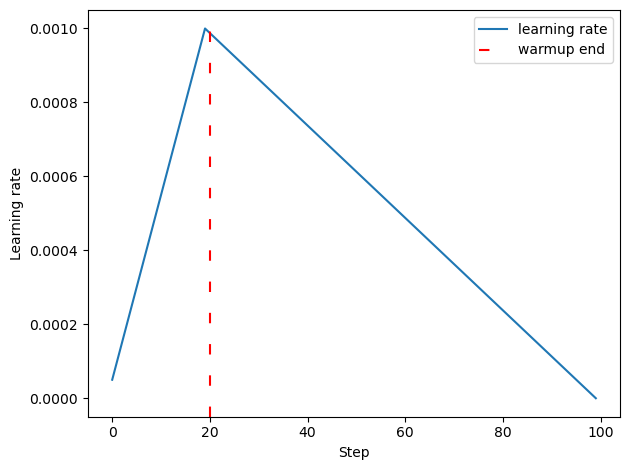

In [28]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();


In [31]:
steps_per_epoch=len(df_train) // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS

In [32]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(250, 1250)

In [33]:
# Instance of the current model
model = RameauLabelClassifier(
  n_classes=len(label_cols),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    monitor='val_loss',# monitored quantity
    filename='Rameau_BertMultilingualClassifier-{epoch:02d}-{val_loss:.2f}',
    verbose=True,
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [35]:
# Log the progress in Tensorboard
logger = TensorBoardLogger("lightning_logs", name="Bert_multilingual")

In [36]:
# Add early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [41]:
# Training
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=EPOCHS,
  accelerator="auto",
  enable_progress_bar=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [42]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 177 M 
1 | classifier | Linear    | 6.1 M 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
183 M     Trainable params
0         Non-trainable params
183 M     Total params
735.850   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

ValueError: `self.log(val_loss, (tensor(0.6989, device='cuda:0'), tensor([[0.5615, 0.4597, 0.4860,  ..., 0.5072, 0.4790, 0.4715],
        [0.5558, 0.5022, 0.5005,  ..., 0.5038, 0.4955, 0.4648],
        [0.5661, 0.4537, 0.4841,  ..., 0.5030, 0.4624, 0.4722],
        ...,
        [0.5376, 0.4711, 0.4738,  ..., 0.4990, 0.4801, 0.4879],
        [0.5228, 0.4673, 0.4977,  ..., 0.4971, 0.4842, 0.4877],
        [0.5616, 0.4837, 0.5029,  ..., 0.4984, 0.4706, 0.4691]],
       device='cuda:0')))` was called, but `tuple` values cannot be logged

In [ ]:
# Initialize the parameters that will be use for training
N_EPOCHS = 12
BATCH_SIZE = 32
MAX_LEN = 300
LR = 2e-05

In [ ]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS ,  accelerator="gpu", callbacks=[checkpoint_callback], enable_progress_bar=True,)
# Train the Classifier Model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `BertForSequenceClassification`

In [ ]:
# Evaluation
criterion = nn.BCELoss()

_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
criterion(predictions, sample_batch["labels"])

tensor(0.6959, grad_fn=<BinaryCrossEntropyBackward0>)

## Training

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="./checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="test_loss",
  mode="min"
)

In [ ]:
trainer.test()

NameError: name 'trainer' is not defined

In [ ]:
# Predictions
trained_model = RameauLabelTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(label_cols)
)
trained_model.eval()
trained_model.freeze()

In [ ]:
# Evaluation
MAX_TOKEN_COUNT = 512


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = RameauLabelDataset(
  df_valid100,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

## Metrics

In [ ]:
# Accuracy
THRESHOLD = 0.7
torchmetrics.Accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
# AUROC
print("AUROC per tag")
for i, name in enumerate(label_cols):
  tag_auroc = torchmetrics.AUROC(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

In [ ]:
# Classification report
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=label_cols,
  zero_division=0
))